# Forecasting store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.
### Using machine learning to predict grocery sales

**This notebook serves as the Prototype1* (20% of features)**

Team Details:
- Somya Sachan
- Harsh Singh
- Narasimha Reddy
- Geetha Murugan
- Rahul Esiripally
- Shahabuddin Syed

In [1]:
# importing modules
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,8)

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# helper function to summarize dataframe
def check_df(dataframe):
    print('*'*30+'Shape of dataframe'+'*'*30)
    print(dataframe.shape)
    print('\n'+'*'*30+'Head of dataframe'+'*'*30)
    print(dataframe.head())
    print('\n'+'*'*30+'Tail of dataframe'+'*'*30)
    print(dataframe.tail())
    print('\n'+'*'*30+'Concise summary of dataframe'+'*'*30)
    print(dataframe.info())
    print('\n'+'*'*30+'Check for missing values'+'*'*30)
    print(dataframe.isnull().sum())
    print('\n'+'*'*30+'Check dataframe for numeric and categorical variables'+'*'*30)
    
    numeric_variables = dataframe.select_dtypes(include=[np.number])
    categorical_variables = dataframe.select_dtypes(exclude=[np.number])

    print('Numeric variables in the given dataframe : ',numeric_variables.shape[1])
    print('Categorical variables in the given dataframe:',categorical_variables.shape[1])

In [3]:
# Load and preprocess the data
all_data = {}
for file in os.listdir('data'):
    filename = file.split('.')[0]
    all_data[filename] = pd.read_parquet('data/{}'.format(file),)

train, stores, holidays_events, oil = (all_data['train'], all_data['stores'], 
         all_data['holidays_events'], all_data['oil'])
for data in (train, holidays_events, oil):
    data['date'] = data['date'].astype('datetime64[ns]')
    
sales_data = train.merge(holidays_events,on='date', how='left')\
                    .merge(oil,on='date', how='left')\
                        .merge(stores,on='store_nbr', how='left')
sales_data = sales_data.drop(['id', 'transferred', 'description','locale_name'], axis=1)
sales_data.rename(columns={'dcoilwtico':'oil_price', "type_x" : "type_holiday", "type_y" : "type_store"}, inplace=True)
sales_data['store_nbr'] = sales_data['store_nbr'].astype(str)
sales_data['cluster'] = sales_data['cluster'].astype(str)
sales_data.head()

,date,store_nbr,family,sales,onpromotion,type_holiday,locale,oil_price,city,state,type_store,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,NaN,Quito,Pichincha,D,13


### Understand Data using descriptive stats

In [4]:
# summarize the data
check_df(sales_data)

******************************Shape of dataframe******************************
(3054348, 12)

******************************Head of dataframe******************************
        date store_nbr      family  sales  onpromotion type_holiday    locale  \
0 2013-01-01         1  AUTOMOTIVE    0.0            0      Holiday  National   
1 2013-01-01         1   BABY CARE    0.0            0      Holiday  National   
2 2013-01-01         1      BEAUTY    0.0            0      Holiday  National   
3 2013-01-01         1   BEVERAGES    0.0            0      Holiday  National   
4 2013-01-01         1       BOOKS    0.0            0      Holiday  National   

   oil_price   city      state type_store cluster  
0        NaN  Quito  Pichincha          D      13  
1        NaN  Quito  Pichincha          D      13  
2        NaN  Quito  Pichincha          D      13  
3        NaN  Quito  Pichincha          D      13  
4        NaN  Quito  Pichincha          D      13  

****************************

### Glimpse on the Avearge daily sales

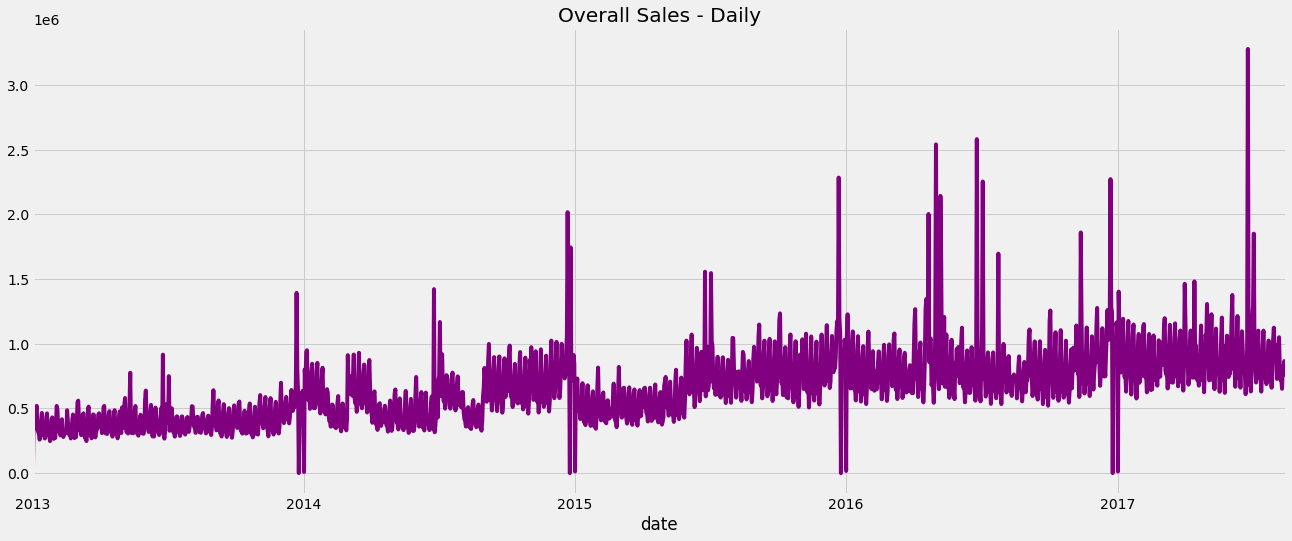

In [5]:
# plot daily sales
sales_data.set_index('date').resample('d').sum()['sales'].plot(title = 'Overall Sales - Daily', color='purple', figsize = (20,8))
plt.show()

In [6]:
# find zero sales during end, check for missing dates
pd.date_range(start = '2014-1-1', end='2017-1-1').difference(sales_data['date'].unique())

DatetimeIndex(['2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

- There seems to be seasonality
- Spike on year end 
- Zero sales on year end is because of missing data on christmas day

### Understanding row count for categorical features

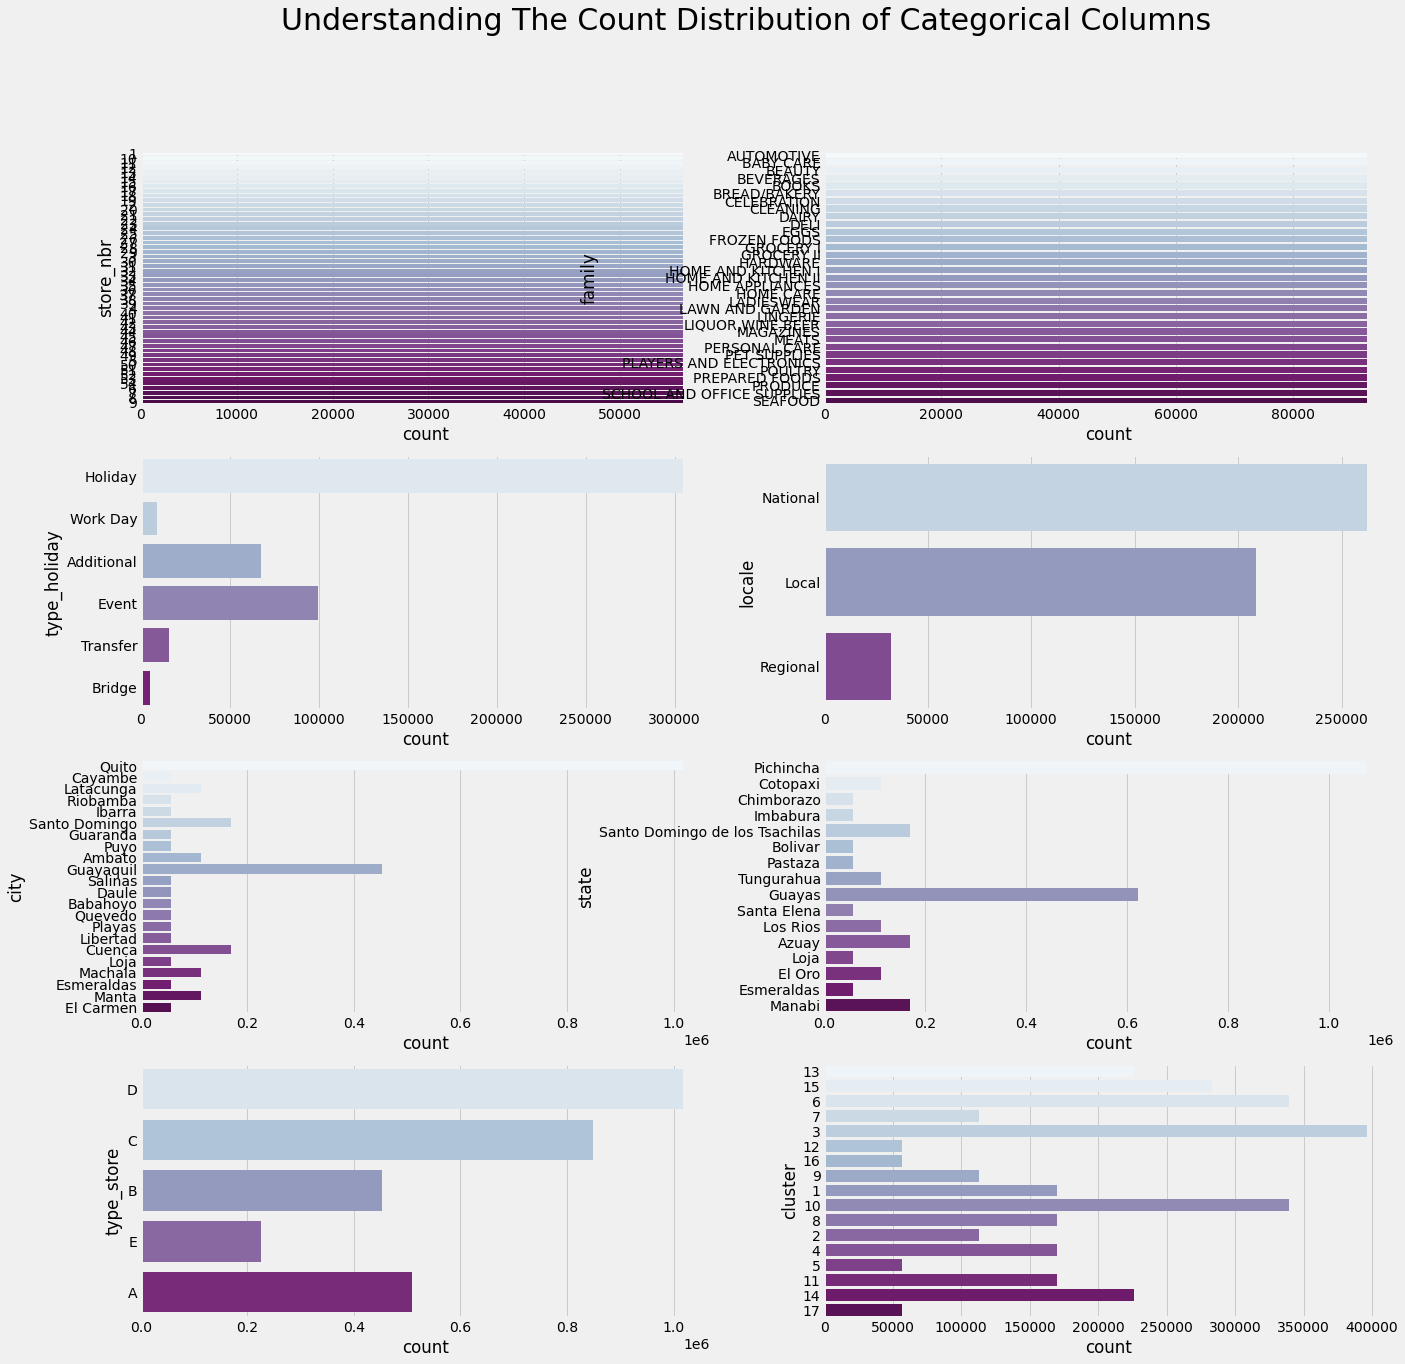

In [7]:
# get categorical columns and find counts
cat_cols = sales_data.select_dtypes(include='object').columns
cat_features = sales_data[cat_cols]

fig , ax = plt.subplots(4,2,figsize = (20,20))     # set up 2 x 2 frame count plot with figsize 20 x 20
fig.suptitle("Understanding The Count Distribution of Categorical Columns", fontsize=30)
for i , subplots in zip (cat_features, ax.flatten()):  
  sns.countplot(y = cat_features[i],ax = subplots, palette = 'BuPu')
  
plt.show()

- The dataset provided in a subset of a big data and while subset they got fixed set of sample for stores and family
- Type_holiday - As per the graph we can see the leading type is natural holidays followed by events and additional holidays. 
- Locale - Leading natural holidays are national the local followed by regional. 
- Top selling city is Quito and Guayaquil.
- Top selling states are Pichincha and Guayas.
- There are four types of stores and most selling stores are of D type followed by C and A.
- Most selling cluster is 3 followed by 6 and 10



### Understanding Sales Distribution On yearly Basis

In [8]:
# Extracting year, month and weekday from date column
sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['weekday'] = sales_data['date'].dt.day_name()

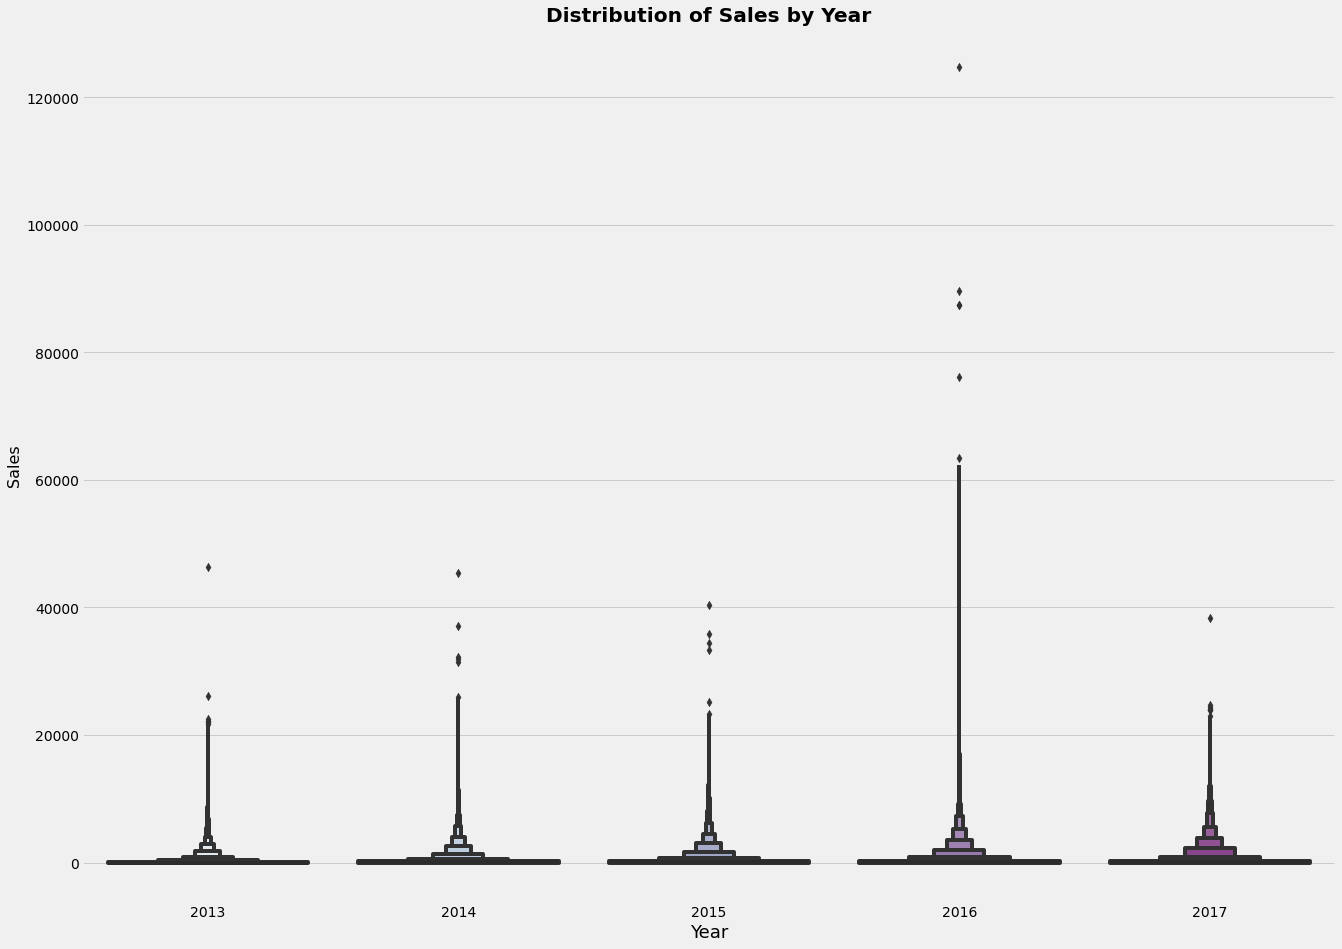

In [9]:
# Enhansed box plot for large datasets
plt.figure(figsize=(20, 15))
sns.boxenplot(x = "year", y = "sales", 
              data = sales_data,palette='BuPu')
plt.title('Distribution of Sales by Year',fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.show()

- Sale is surprisingly up in 2016 and then went drastically down in 2017 it was almost consistent during last three years before 2016 despite of outliers 

### Analysis on Average sales per day of the week, Month, Year

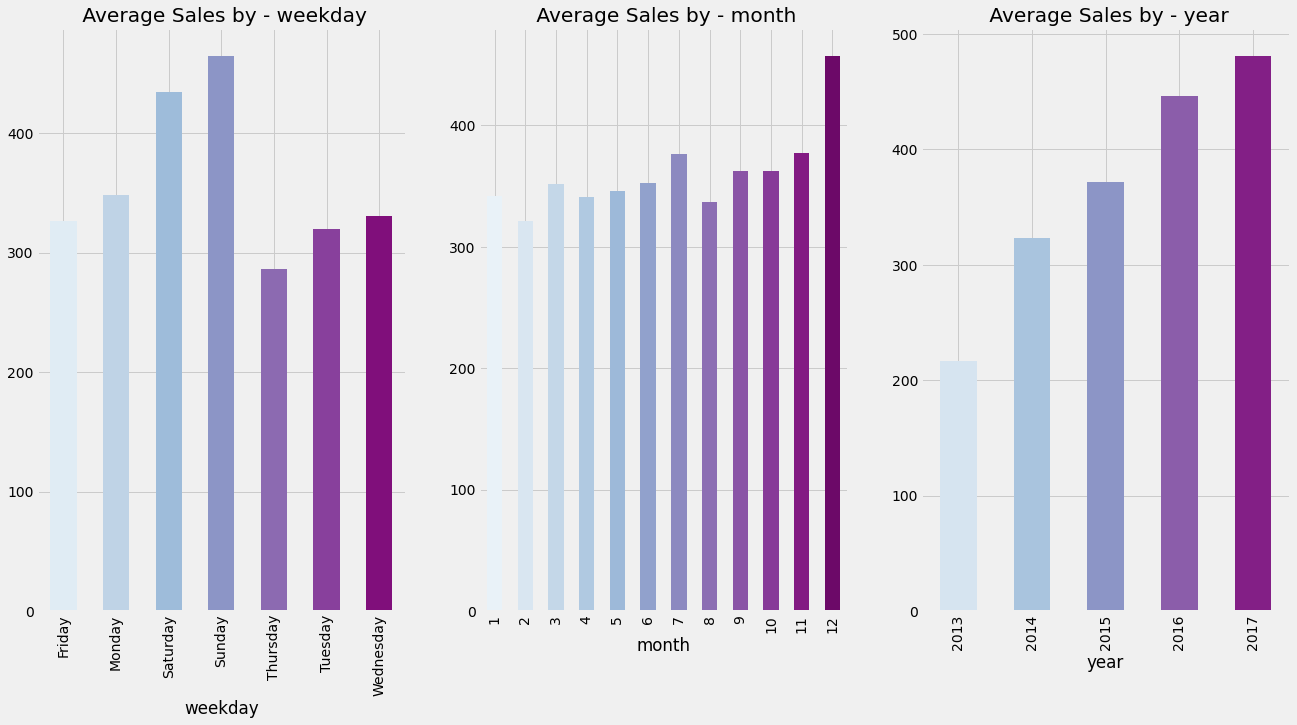

In [10]:
fig , ax = plt.subplots(1,3,figsize = (20,10))
for i, p in enumerate([ 'weekday', 'month', 'year']):
    p_df = sales_data.groupby(p)['sales'].mean()
    p_df.plot.bar(title = f' Average Sales by - {p}', ax = ax[i], color =sns.color_palette('BuPu', len(p_df)))
    

- Most sales making days are weekends and Monday.
- Most selling month is holiday seasons months - December and July. 
- Most selling year is 2017 followed by 2016 and so on. 


### Analysis on Numbers of stores vs Average sales per category

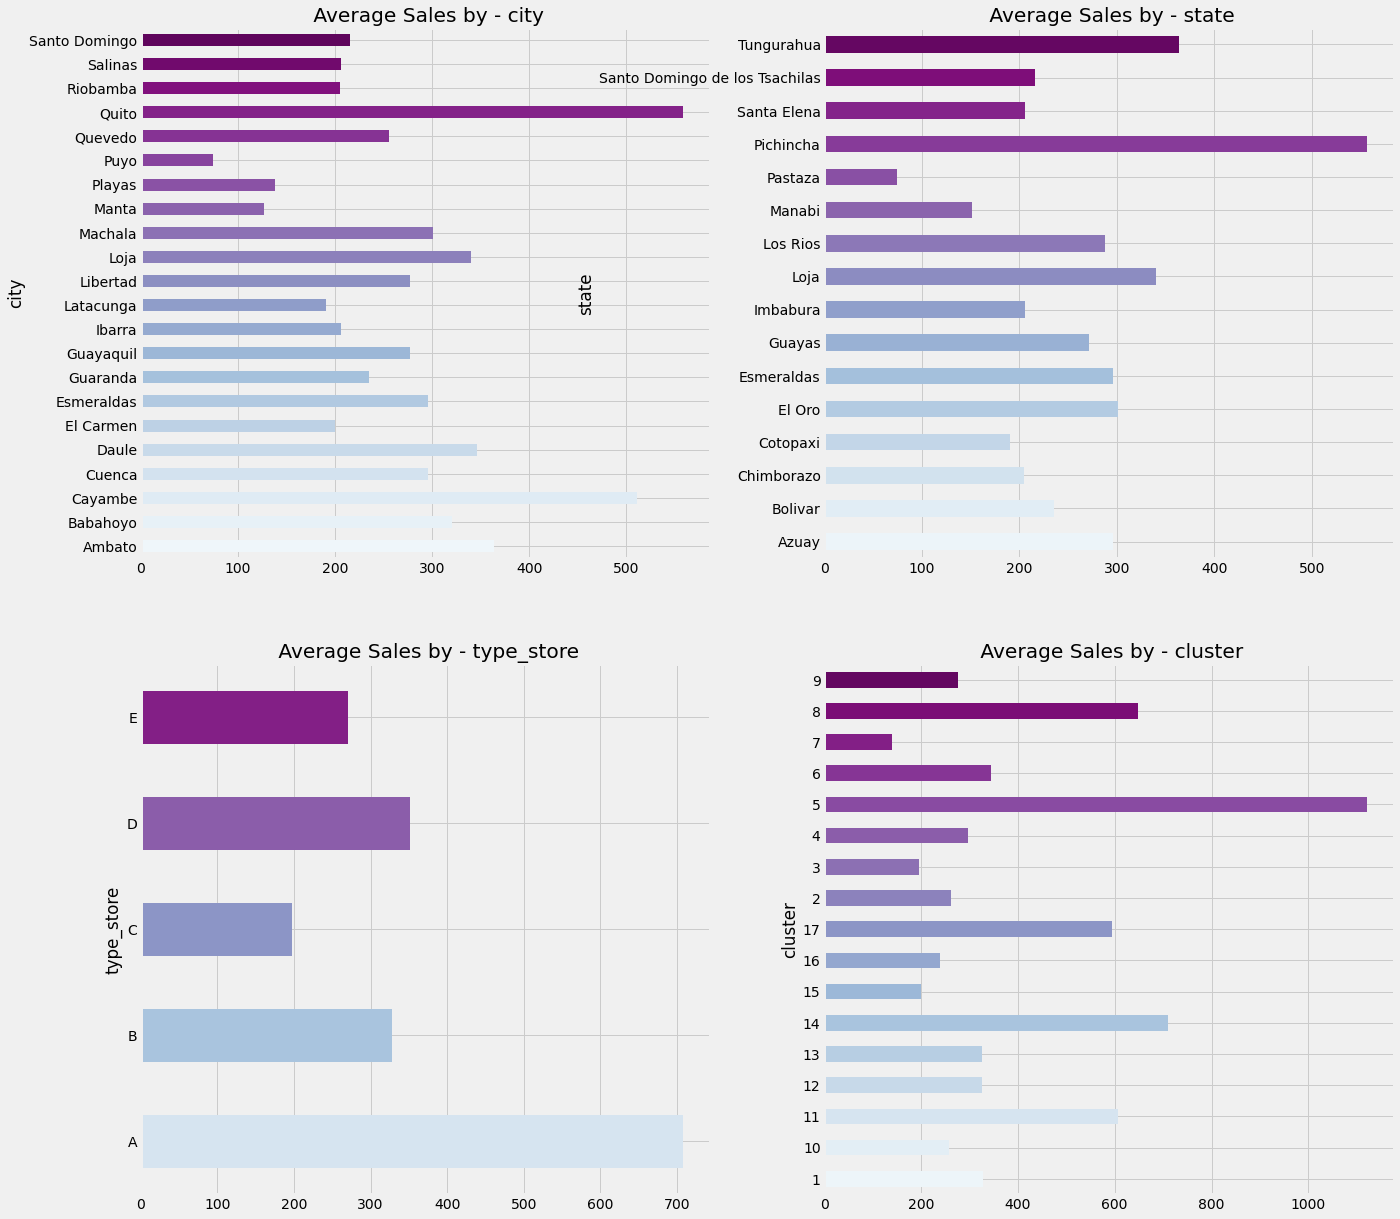

In [11]:
fig , ax = plt.subplots(2,2,figsize = (20,20))
ax = ax.flatten()
for i, p in enumerate(['city', 'state', 'type_store', 'cluster']):
    p_df = sales_data.groupby(p)['sales'].mean()
    p_df.plot.barh(title = f' Average Sales by - {p}', ax = ax[i], color =sns.color_palette('BuPu', len(p_df)))

- Most sales by city is Quito and Cayambe
- Most sales by state is Pichnicha and Tungurahua
- Most selling store is A followed by D 
- Most selling cluster is 5 followed by 14



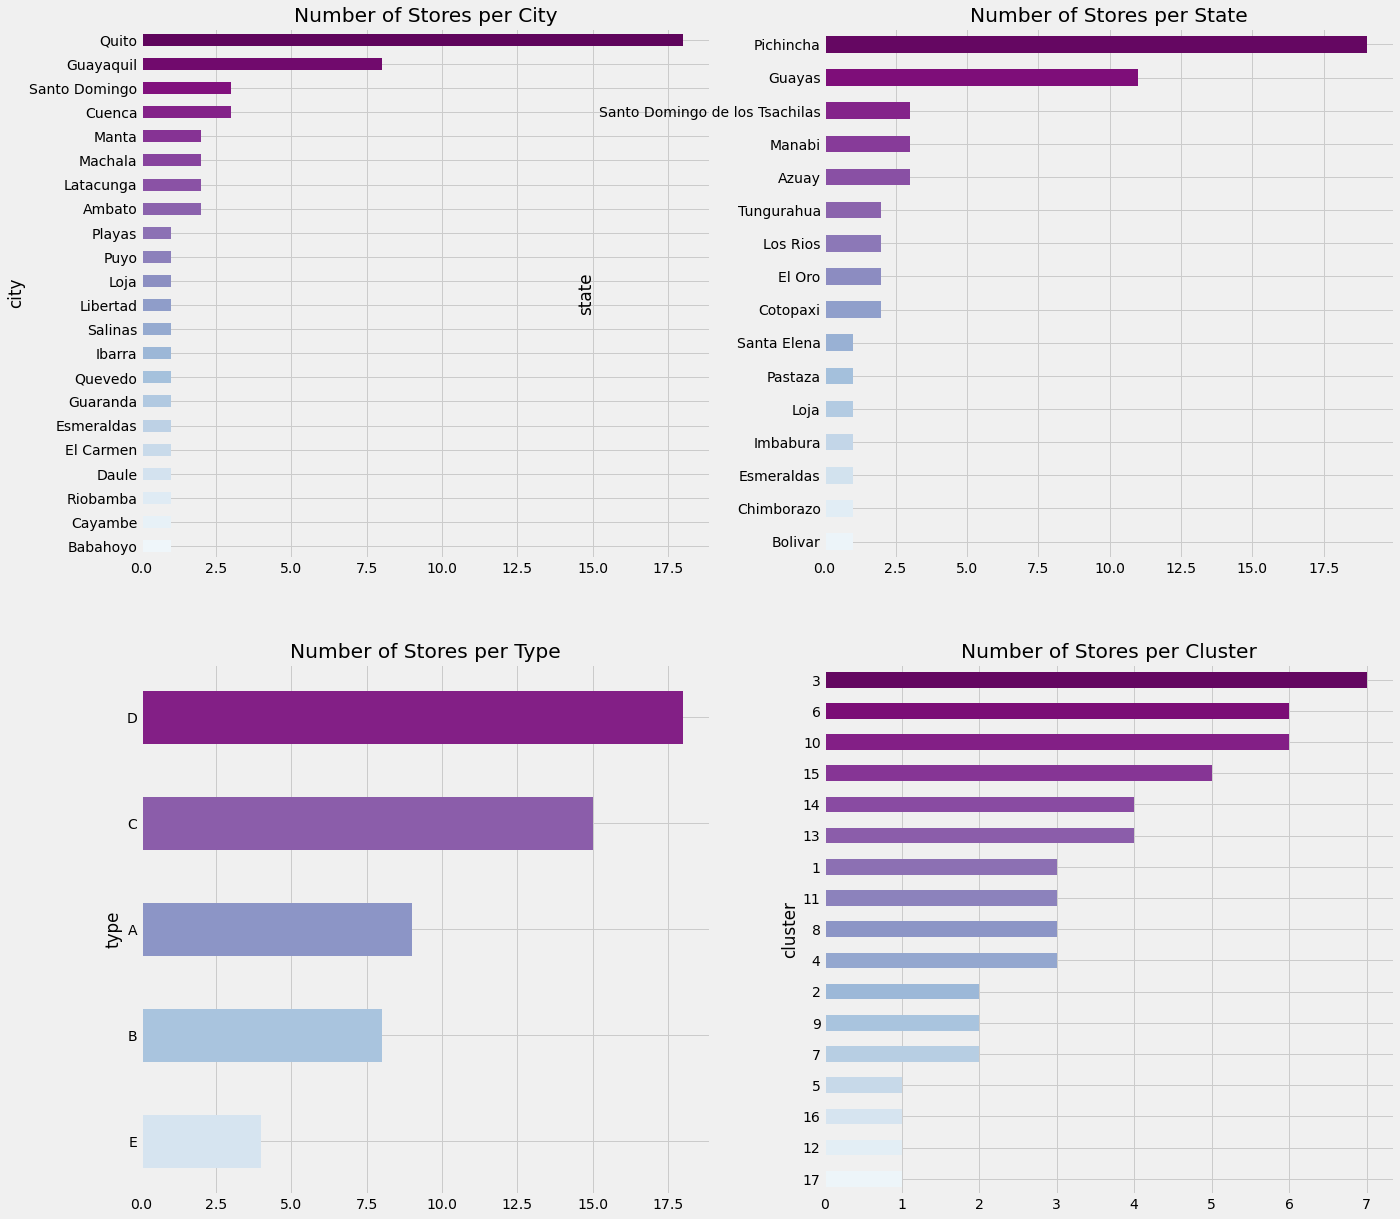

In [12]:
fig, ax = plt.subplots(2,2, figsize = (20,20))
ax = ax.flatten()
for i, col in enumerate(['city', 'state', 'type', 'cluster']):
    p_df = stores.groupby(col)['store_nbr'].count().sort_values()
    p_df.plot.barh(title = 'Number of Stores per {}'.format(col.capitalize()), ax=  ax[i],
                                                                     color =sns.color_palette('BuPu', len(p_df)))


- After comparison we understand why most stores located in Quito. it has the highest average sales
- Most stores are located in Pichincha Sate which has the highest average sales.
- However most of the store type are D followed by C and D is second in selling position. 
- Cluster 3 has highest number of stores however still is not highest selling cluster, followed by 6 and 10


In [13]:
# Correlation with oil prices
sales_data.set_index('date').resample('d').mean()[['sales','oil_price']].corr()


,sales,oil_price
sales,1.000000,-0.705002
oil_price,-0.705002,1.000000


- Oil prices have Negative correlation with sales

### Does More Promotion days have more sales?

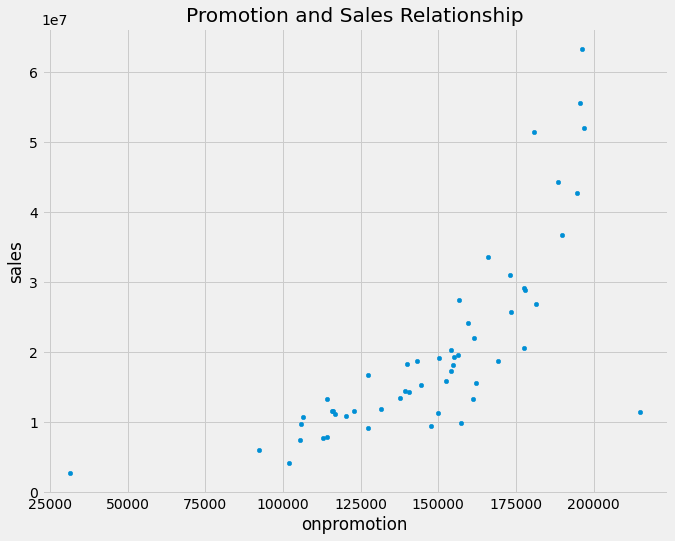

In [14]:
# promotion vs sales relation ship
sales_data.groupby('store_nbr')[['onpromotion','sales']].sum().plot.scatter('onpromotion','sales')
plt.title('Promotion and Sales Relationship')
plt.show()

- x axis  = number of on promotion days for stores
- y-axis = sum of sales
- Insight <br>
 This plots answers the question does more on promotion days have more sales?
 Answer = Yes
 More on promotion days more the sales 

References :
- https://www.kaggle.com/code/sachinprabhu007/store-sales-eda-time-series
- https://seaborn.pydata.org/generated/seaborn.boxenplot.html
